# Data period features

This notebook characterizes the following features for each water quality data period:
- Operational: average daily DMA inflow, number of pressure events
- Environmental: average and range of daily DMA inlet chlorine, average temperature
- Calendar: season, day of week

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from bayesian_wq_calibration.simulation import model_simulation
from bayesian_wq_calibration.constants import TIMESERIES_DIR

In [6]:
# load operational data
data_period = 10 # 28 calibration events

try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
except:
    print(f"Data period {data_period} does not exist.")

Sensor lag function:
1. Compute matrix of lag values between sensors
    - hydraulic model
    - time series data
    
Set unconnected sensors NaN values

Data cleaning function:
1. Check that duplicate sensors are within +/- 0.025 mg/L.
2. Check that BW1 > BW12 + lag > (BW3, BW7, BW6) + respective lags & BW4 > BW9 + lag & (BW3 > BW5 + lag or BW9 > BW5 + lag) & (BW3 > BW2 + lag or BW4 > BW2 + lag) NB: all values need to be within a +/- 0.025 mg/L threshold.
3. Check sudden changes in readings isolated to individual sensors.

Make datetime rows NaN values if these conditions are violated.

Chlorine time series plotting.

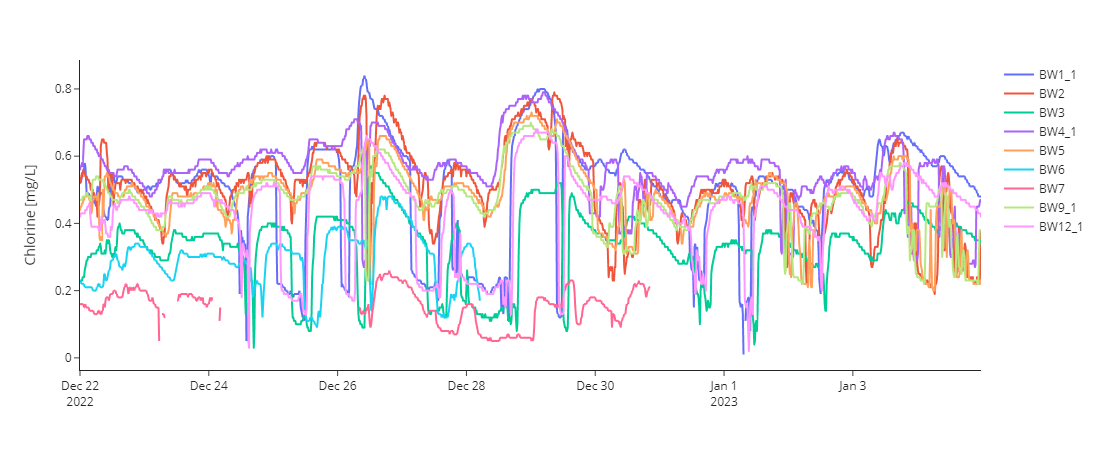

In [7]:
# chlorine data
try:
    wq_bwfl_ids = wq_df.dropna(subset=['mean'])['bwfl_id'].unique()
    plot_wq_df = wq_df[(wq_df['bwfl_id'].isin(wq_bwfl_ids)) & (wq_df['data_type'] == 'chlorine')]
    plot_wq_df.loc[:, :] = plot_wq_df.loc[:, :].replace(0.0, np.nan)

    fig = px.line(
        plot_wq_df,
        x='datetime',
        y='mean',
        color='bwfl_id',
    )

    fig.update_layout(
        xaxis_title='',
        yaxis_title='Chlorine [mg/L]',
        legend_title_text='',
        template='simple_white',
        height=450,
    )
    fig.show()
except:
    print("Plotting data not available.")

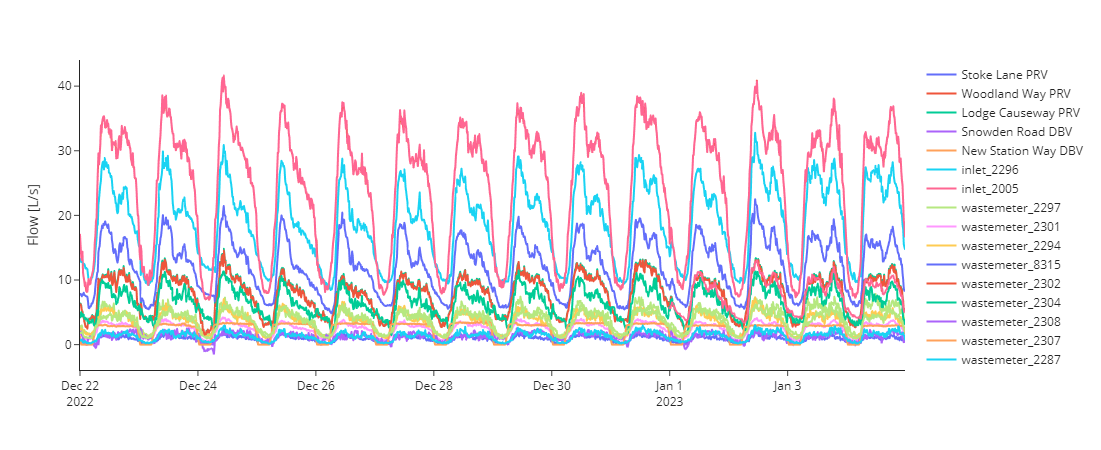

In [8]:
# flow data
try:
    flow_bwfl_ids = flow_df.dropna(subset=['mean'])['bwfl_id'].unique()
    plot_flow_df = flow_df[flow_df['bwfl_id'].isin(flow_bwfl_ids)]

    fig = px.line(
        plot_flow_df,
        x='datetime',
        y='mean',
        color='bwfl_id',
    )

    fig.update_layout(
        xaxis_title='',
        yaxis_title='Flow [L/s]',
        legend_title_text='',
        template='simple_white',
        height=450,
    )
    fig.show()
except:
    print("Plotting data not available.")

In [9]:
results = model_simulation(flow_df, pressure_df, wq_df, demand_resolution='wwmd')

Error setting boundary head values at reservoir node_2860. Default values used.
Error setting DBV settings. Default values used.
Error setting PRV settings. Default values used.
                     2301_2303      2332      2302      2304  2293_2294  \
datetime                                                                  
2022-12-22 00:00:00   8.767054  1.844445  4.435408  5.441925   4.757339   
2022-12-22 00:15:00   7.656602  1.788889  4.354782  5.095184   4.679426   
2022-12-22 00:30:00   6.817317  1.800000  4.041049  5.038017   4.333061   
2022-12-22 00:45:00   6.924183  1.911111  3.828883  4.358329   4.219060   
2022-12-22 01:00:00   8.180710  2.066667  3.519462  4.791491   4.266291   
...                        ...       ...       ...       ...        ...   
2023-01-04 22:45:00  11.698470  3.622222  6.514281  8.251642   5.748487   
2023-01-04 23:00:00  10.602595  2.944445  5.841455  6.964628   6.140696   
2023-01-04 23:15:00   9.412380  2.555556  5.100450  5.896889   5.301265 